<a href="https://colab.research.google.com/github/aranpandey/CornyWebbedRegisters/blob/master/Temp_Mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
import DLYHandler
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import datetime
from DLYHandler import read_ghcn_data_file

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


Mounted at /content/gdrive/


In [23]:
import pandas as pd
#df = ! wget https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmaxst-v1.0.0-20230406
! wget -P '/content/gdrive/My Drive/Colab Notebooks' https://github.com/aranpandey/CornyWebbedRegisters/raw/master/climdiv-tmaxst-v1.0.0-20230406
def readfileName(fileName, stateCode):
  colspecs = [(0, 10), (11, 17), (18, 24), (25, 31), (32, 38), (39, 45), (46,52), (53,59), (60,66), (67,73), (74,80), (81,87), (88,94)]
  colnames = ['metainfo', '01', '02', '03','04','05','06','07','08','09','10','11','12']
  df = pd.read_fwf(fileName, colspecs=colspecs, names=colnames, converters = {'metainfo':lambda x : str(x)})
  df['stateCode'] = df['metainfo'].str[:3]
  df['Year'] = df['metainfo'].str[6:10]
  df = df[(df['stateCode'] == '110')]

  return df
  
  
  #TBD Reassess this method to see if we only take upper bound for TMX and lower bound fro TMIN. Yes choosing to do this now
def classifyIfInRange(row):
    #if row['TMAX'] < row['ci_low']:
     #   return 1
    #elif row['TMAX'] >row['ci_high']:
    if row['tmax'] >row['ci_high']:
        return 1
    else:
     return 0


def mean_confidence_interval(df_small, confidence=0.95):
    m=df_small['tmax'].mean()

    se=st.sem(df_small['tmax'] )
    
    h=st.norm.interval(0.95,m,se)
    
    return m, h

#This function calculates the mean and confidence interval for each week of the year. That is for 52 weeks.
#Need to do this for each year. TBD- adust the function to do for each year.
def populate_weekly_confidence(base_data,all_data):
    #loop through each record to find mean confidence interval for each row
    for i in range(1, 53):
       df_week= base_data [(base_data['Week'] ==i)] 
       upper_alt=mean_confidence_interval(df_week)    
       all_data.loc[all_data['Week'] == i, 'ci_low'] = upper_alt[1][0]
       all_data.loc[all_data['Week'] == i, 'ci_high'] = upper_alt[1][1]
    
def populate_monthly_confidence(base_data,all_data):
    for i in range(1, 13):
       df_month= base_data [(base_data['month'] ==i)] 
       upper_alt=mean_confidence_interval(df_month)    
       all_data.loc[all_data['month'] == i, 'ci_low'] = upper_alt[1][0]
       all_data.loc[all_data['month'] == i, 'ci_high'] = upper_alt[1][1]


  


    

--2023-05-17 05:20:44--  https://github.com/aranpandey/CornyWebbedRegisters/raw/master/climdiv-tmaxst-v1.0.0-20230406
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aranpandey/CornyWebbedRegisters/master/climdiv-tmaxst-v1.0.0-20230406 [following]
--2023-05-17 05:20:44--  https://raw.githubusercontent.com/aranpandey/CornyWebbedRegisters/master/climdiv-tmaxst-v1.0.0-20230406
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223334 (1.2M) [text/plain]
Saving to: ‘/content/gdrive/My Drive/Colab Notebooks/climdiv-tmaxst-v1.0.0-20230406’

climdiv-tmaxst-v1.0 100%[===================>]   1.17M  --.

In [19]:
#readfileName('https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmaxst-v1.0.0-20230406', '110')
df = readfileName('https://www.ncei.noaa.gov/data/climdiv/access/climdiv-tmaxst-v1.0.0-20230406', '110')

df.head()
df = df.melt(['metainfo','stateCode','Year'],var_name = 'month', value_name = 'tmax')
df['month'] = df['month'].astype(int)
df['Year'] = df['Year'].astype(int)
df.head()

base_data = df[(df['Year'] <= 1999)]
base_data.tail()

df.head()

populate_monthly_confidence(base_data,df)

df["EHE"] = df.apply(lambda row: classifyIfInRange(row), axis=1)
df.head()

df_w = df.groupby('Year')['EHE'].sum().reset_index()
df_w2 = df.groupby('Year')['tmax'].mean().reset_index()
df_w = pd.merge(df_w, df_w2, on = 'Year')

df_w.head()




,Year,EHE,tmax
0,1895,2,62.571667
1,1896,7,63.735833
2,1897,3,63.395833
3,1898,4,63.309167
4,1899,2,62.930000


In [20]:
! wget -P '/content/gdrive/My Drive/Colab Notebooks/' https://github.com/aranpandey/CornyWebbedRegisters/raw/master/Deaths_1x1.csv
#df_mor=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Deaths_1x1.csv')
df_mor.head()
df_mor.columns = df_mor.columns.str.replace(' ', '')
df_mor_year = df_mor.groupby(['Year'])['Total'].sum().reset_index()
print(df_mor['Year'].agg(['min', 'max']))

df_mor_year.tail(500)
len(df_mor)
df_mor.head(1000)
df_mor['Year'] = df_mor['Year'].str.strip()
df_mor['Year'] = df_mor['Year'].str[:4]
df_mor_year = df_mor.groupby(['Year'])['Total'].sum().reset_index()

df_mor_year.head()

--2023-05-17 05:17:25--  https://github.com/aranpandey/CornyWebbedRegisters/raw/master/Deaths_1x1.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aranpandey/CornyWebbedRegisters/master/Deaths_1x1.csv [following]
--2023-05-17 05:17:25--  https://raw.githubusercontent.com/aranpandey/CornyWebbedRegisters/master/Deaths_1x1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 711361 (695K) [text/plain]
Saving to: ‘/content/gdrive/My Drive/Colab Notebooks/Deaths_1x1.csv.1’

Deaths_1x1.csv.1    100%[===================>] 694.69K  --.-KB/s    in 0.03s   

2023-05-17 05:17:25 (23.4 MB/s) - ‘/conte

,Year,Total
0,1933,1342105.95
1,1934,1396903.06
2,1935,1392751.95
3,1936,1479228.21
4,1937,1450426.97


In [21]:
df.dtypes
df_mor_year['Year'] = df_mor_year['Year'].astype('int64')

df['Year'] = df['Year'].astype('int64')
df_w.astype('int64')
df_merged= pd.merge(df_mor_year, df_w, on="Year", how = 'left').reset_index() 
df_merged.head(10)


,index,Year,Total,EHE,tmax
0,0,1933,1342105.95,7,65.407500
1,1,1934,1396903.06,10,66.762500
2,2,1935,1392751.95,6,63.676667
3,3,1936,1479228.21,7,64.602500
4,4,1937,1450426.97,4,63.439167
5,5,1938,1381391.04,8,65.215833
6,6,1939,1387897.03,10,65.905833
7,7,1940,1417269.06,6,63.732500
8,8,1941,1397641.93,5,64.084167
9,9,1942,1385187.11,4,63.845000


In [6]:
inputs = df_merged['Total'].to_numpy()             
outputs = df_merged['Total'].to_numpy()
inputs1 = df_merged['EHE'].to_numpy()             

df.tail(5)
days = []
count = 0
for elements in inputs:
  count += 1
  days.append(count)
df_merged['elapsed'] = days
df_merged.head()



,index,Year,Total,EHE,tmax,elapsed
0,0,1933,1342105.95,7,65.407500,1
1,1,1934,1396903.06,10,66.762500,2
2,2,1935,1392751.95,6,63.676667,3
3,3,1936,1479228.21,7,64.602500,4
4,4,1937,1450426.97,4,63.439167,5


84
17
62075.93314738229
17
0.8161720686166282
17009441584.975536
130420.2499038226


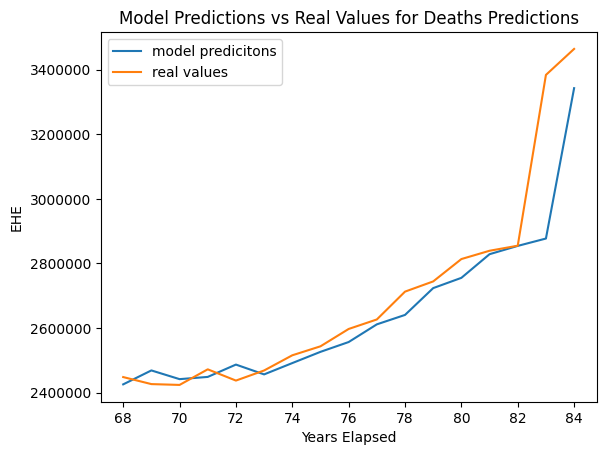

In [7]:
#Cell is for Autoregressive Linear Regression
#Experiment 1 uses EHE and mortality to predict mortality
days=df_merged['elapsed']

past = 5
s = (len(inputs) , past  * 1)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))

for i in range(len(inputs) - past): # - 0
  temp = np.zeros(past * 1)
  temp[0 : past] = inputs[i : i+ past]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged) - past] # - 0
betteroutputs = betteroutputs[0:len(df_merged) - past]
days = days[0:len(df_merged) - past]
print(len(days))

from matplotlib import pyplot as plt
split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)  
X_test = np.expand_dims(X_test, axis=2) 
days = days[split:]
print(len(days))

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
model = RidgeCV(cv = 2)
#model = LinearRegression()
#model = GradientBoostingRegressor()

X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)
print("{}".format(np.linalg.norm(model.predict(X_test) - y_test, 1)/len(y_test)))
predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')

print(len(days))

plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()
cross_val_score(model, X_train, y_train, cv = 2)

from sklearn.metrics import mean_squared_error
print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)


86
18
61897.643331033876
18
0.8280019348382085
15814679981.718296
125756.43117438685


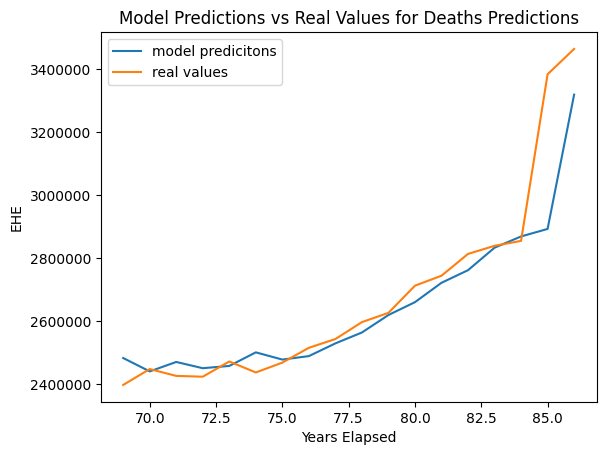

In [8]:
#Cell is for Autoregressive Linear Regression
#Experiment 2 uses EHE and mortality to predict mortality
days=df_merged['elapsed']

past = 3
s = (len(inputs) , past *2)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))

for i in range(len(inputs) - past): # - 0
  temp = np.zeros(past*2)
  temp[0 : past] = inputs1[i : i+ past]
  temp[past:] = outputs[i : i + past] 
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged) - past] # - 0
betteroutputs = betteroutputs[0:len(df_merged) - past]
days = days[0:len(df_merged) - past]
print(len(days))

from matplotlib import pyplot as plt
split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)  
X_test = np.expand_dims(X_test, axis=2) 
days = days[split:]
print(len(days))

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
model = RidgeCV(cv = 2)
#model = LinearRegression()
#model = GradientBoostingRegressor()

X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)
print("{}".format(np.linalg.norm(model.predict(X_test) - y_test, 1)/len(y_test)))
predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')

print(len(days))

plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()
cross_val_score(model, X_train, y_train, cv = 2)

from sklearn.metrics import mean_squared_error
print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

89
(89,)
18
18
18


array([0.93936633, 0.93275429])

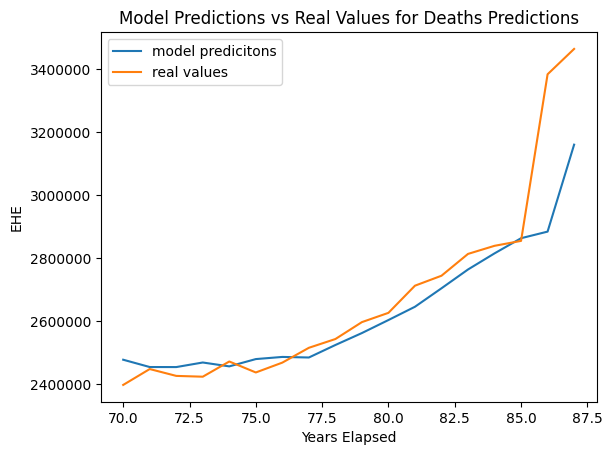

In [9]:
#Simple Moving Avg Linear Regresison
from numpy.ma.core import mean
from matplotlib import pyplot as plt

days=df_merged['elapsed']
print(len(days))
past = 2
s = (len(inputs) ,1)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))


for i in range (len(inputs)-past):
  temp = np.zeros(1)  
  me = np.mean(inputs[i:i+past])
  temp[0] = me
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]


print(betteroutputs.shape)

betterinputs = betterinputs[0:len(df_merged) - past] # - 0

days = days[0:len(df_merged) - past]

betteroutputs = betteroutputs[0:len(df_merged) - past]



split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)  
X_test = np.expand_dims(X_test, axis=2) 
days = days[split:]

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
#model = RidgeCV(cv = 2)
model = LinearRegression()
#model = GradientBoostingRegressor()

X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)
print(len(X_test))
predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')
print(len(days))
print(len(predict))
plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()
cross_val_score(model, X_train, y_train, cv = 2)


In [10]:
print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

0.7790749535301056
20313361703.11621
142524.95115984502


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2885.
Date:                Wed, 17 May 2023   Prob (F-statistic):           7.63e-79
Time:                        05:08:18   Log-Likelihood:                 190.44
No. Observations:                  88   AIC:                            -374.9
Df Residuals:                      85   BIC:                            -367.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6807      0.038    359.848      0.0

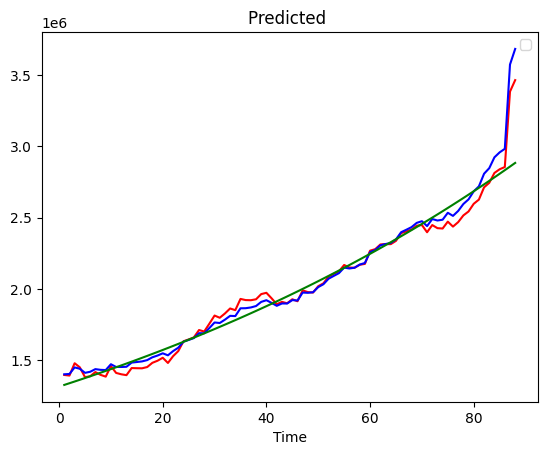

In [11]:
#Exponential Regression ( I do both experiment 1 and experiment 2 here)
import statsmodels.api as sm

days=df_merged['elapsed']

past = 1
s = (len(inputs) , 2 )
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))


for i in range(len(inputs) - past ): # - 0
  temp = np.zeros(2)
  temp[0 : 1 ]= days[i]
  temp[1: ] = inputs[i]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged)-past] # - 0
betteroutputs = betteroutputs[0:len(df_merged)-past]
days = days[0:len(df_merged)-past]

log_deaths = np.log(betteroutputs)
X = betterinputs
X = sm.add_constant(X)
y = log_deaths
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
c = res.params[0]
b = res.params[1]
d = res.params[2]


predictions = np.exp(c) * np.exp(b) ** days * np.exp(d) ** inputs[1:]

days=df_merged['elapsed']
past = 1
s = (len(inputs),1)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))

for i in range(len(inputs)-past): # - 0
  temp = np.zeros(1)
  temp[:1 ] = inputs[i]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged)-past] # - 0
betteroutputs = betteroutputs[0:len(df_merged)-past]
days = days[0:len(df_merged)-past]

log_deaths= np.log(betteroutputs)
X = days
X = sm.add_constant(X)
y = log_deaths
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
c = res.params[0]
b = res.params[1]


predictions1 = np.exp(c) * np.exp(b) ** days

res.params





plt.plot(days, betteroutputs, 'red')
plt.plot(days, predictions,  'blue')
plt.plot(days, predictions1,  'green')

plt.title('Predicted ')
plt.xlabel('Time')
plt.ylabel('')
plt.legend()





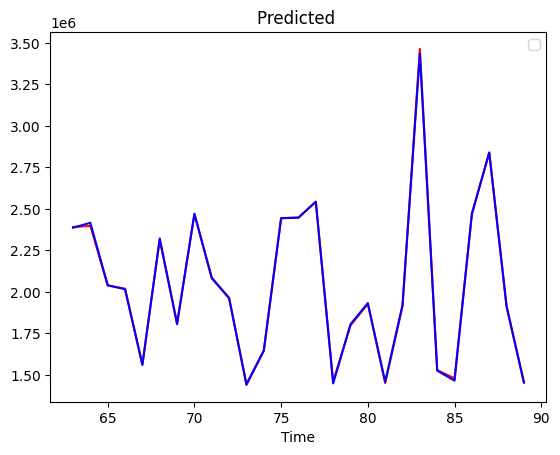

In [12]:
#This is multi Layer perceptron

from numpy import hstack
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
days = df_merged['elapsed']
def split_sequences(sequences, n_steps):
 X, y = list(), list()
 for i in range(len(sequences)):
 # find the end of this pattern
  end_ix = i + n_steps
 # check if we are beyond the dataset
  if end_ix > len(sequences):
    break
 # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
  X.append(seq_x)
  y.append(seq_y)
 return array(X), array(y)


in_seq1 = inputs
in_seq2 = inputs1
out_seq = outputs

in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

#print(dataset)


n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)



n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
# demonstrate prediction
s_ratio = (1-0.7)
split = int(0.7*len(inputs))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s_ratio)
model.fit(X_train, y_train, epochs=2000, verbose=0)
yhat = model.predict(X_test, verbose=0)


days = days[split:]
plt.plot(days, y_test, 'red')
plt.plot(days,  yhat,  'blue')
plt.title('Predicted ')
plt.xlabel('Time')
plt.ylabel('')
plt.legend()


In [ ]:
! wget https://www.mortality.org/File/GetDocument/hmd.v6/USA/STATS/Deaths_1x1.txt


--2023-05-15 16:15:47--  https://www.mortality.org/File/GetDocument/hmd.v6/USA/STATS/Deaths_1x1.txt
Resolving www.mortality.org (www.mortality.org)... 195.37.34.103
Connecting to www.mortality.org (www.mortality.org)|195.37.34.103|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /Account/Login [following]
--2023-05-15 16:15:48--  https://www.mortality.org/Account/Login
Reusing existing connection to www.mortality.org:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Deaths_1x1.txt’

Deaths_1x1.txt          [ <=>                ]  11.23K  --.-KB/s    in 0s      

2023-05-15 16:15:48 (244 MB/s) - ‘Deaths_1x1.txt’ saved [11498]

